In [2]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,StyblinskiTang
import obj_functions.push_problems
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


function_information = []

temp={}
temp['name']='Push4D' 
f_class = obj_functions.push_problems.push4
tx_1 = 3.5; ty_1 = 4
fun = f_class(tx_1, ty_1)
temp['function'] = fun
temp['fstar'] =  0.
function_information.append(temp)

# temp={}
# temp['name']='Branin2D' 
# temp['function'] = Branin(negate=False)
# temp['fstar'] =  0.397887 
# function_information.append(temp)

# temp={}
# temp['name']='Beale2D' 
# temp['function'] = Beale(negate=False)
# temp['fstar'] =  0. 
# function_information.append(temp)

# temp={}
# temp['name']='Ackley2D' 
# temp['function'] = Ackley(dim=2,negate=False)
# temp['fstar'] =  0. 
# function_information.append(temp)

# temp={}
# temp['name']='SixHumpCamel2D' 
# temp['function'] = SixHumpCamel(negate=False)
# temp['fstar'] =  -1.0317
# function_information.append(temp)

# temp={}
# temp['name']='Hartmann3D' 
# temp['function'] = Hartmann(dim=3,negate=False)
# temp['fstar'] =  -3.86278
# function_information.append(temp)

In [4]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 20
    fstar = information['fstar']
    
    print('fstar is: ',fstar)
    
    if dim <=3:
        step_size = 2
        iter_num = 50
    elif dim<=7:
        step_size = 3
        iter_num = 100 #120
    else:
        step_size = 4
        iter_num = 200
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,16]
    noise = 1e-6
    
    print(information['name'])
    
    
     ######################## SlogGP+logEI#######################################
    LogEI_noboundary = []

    for exp in range(N):

        seed = exp+20
        
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        np.random.seed(1234)

        for i in range(iter_num):

                print('inner loop: ',i)
            
                train_Y = Y_BO.numpy()
                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
                
                train_Y_std = np.std(train_Y)
                lower = -np.min(train_Y)+10**(-6)
                upper = min(300,5*train_Y_std) #lower+2000 #
                
                c_range = [lower,upper]

                if i%step_size == 0:
                    
                    parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    c = parameters[2]
                    
                    print('lengthscale is ',lengthscale)
                    print('variance is ',variance)
                    print('lower bound is ',-c)
                
                
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
                
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
                best_record.append(Y_BO.min().item())
                print(best_record[-1])
                
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                #print('noise: ',noise)
                
                
        best_record = np.array(best_record)         
        LogEI_noboundary.append(best_record)

fstar is:  0.0
Push4D
0
inner loop:  0
lengthscale is  0.10673981336293699
variance is  0.08364632025172401
lower bound is  -7.258913014485859
0.4866610799835017
inner loop:  1
0.4866610799835017
inner loop:  2
0.4866610799835017
inner loop:  3
lengthscale is  0.02696340733120297
variance is  0.10018453860417362
lower bound is  -5.814067620937892
0.4866610799835017
inner loop:  4
0.4866610799835017
inner loop:  5
0.4866610799835017
inner loop:  6
lengthscale is  0.021033549255608977
variance is  0.14815312123868898
lower bound is  -3.864353215603075
0.4866610799835017
inner loop:  7
0.4866610799835017
inner loop:  8
0.4866610799835017
inner loop:  9
lengthscale is  0.01617047392935717
variance is  0.1794373444087108
lower bound is  -3.2301282786353456
0.4866610799835017
inner loop:  10
0.4866610799835017
inner loop:  11
0.4866610799835017
inner loop:  12
lengthscale is  0.015523719597642587
variance is  0.27997611852837934
lower bound is  -1.7557941626510574
0.4866610799835017
inner lo

KeyboardInterrupt: 

In [5]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 20
    fstar = information['fstar']
    
    print('fstar is: ',fstar)
    
    if dim <=3:
        step_size = 2
        iter_num = 50
    elif dim<=7:
        step_size = 3
        iter_num = 100 #120
    else:
        step_size = 4
        iter_num = 200
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,4**2]
    noise = 1e-6
    
    print(information['name'])
    
    
 ######################## SlogGP (boundary)+logEI#######################################
    
    LogEI_boundary = []
    
    for exp in range(N):

        seed = exp+20
        
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        print(best_record[-1])
        np.random.seed(1234)
        
        #PriorInformation = True
        uncertainty_index = 1
        tolerance_level = 2.5
        
        for i in range(iter_num):

                print('inner loop: ',i)
                print('uncertainty: ',uncertainty_index)
            
                train_Y = Y_BO.numpy()
                fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
                #print('shift lower bound: ',fstar_shifted)
                train_Y = train_Y - np.min(train_Y)  # shift Y
                #print('std: ',np.std(train_Y))
                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
                
                lower = -np.min(train_Y)+10**(-6)
                upper = min(300,5*train_Y_std) #lower+2000 
                c_range = [lower,upper]
                        
                
                mu_prior =  np.log(-fstar_shifted+ 0.1)   #np.log(-fstar_shifted)  #np.log(-fstar_shifted+ 0.3)  
                sigma_prior =  np.sqrt(np.log(-fstar_shifted+0.1)-np.log(-fstar_shifted)) #0.1*uncertainty_index       #np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
                prior_parameter = [mu_prior,sigma_prior]
                
   
                if i%step_size == 0:
                    
                    if uncertainty_index<=25:
                    

                        #best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
                        best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,c_range,
                                prior_parameter,noise=noise,seed=i)
                        lengthscale = best_parameter[0]
                        variance = best_parameter[1]
                        c = best_parameter[2]
                        
                        #print('-c: ',-c)
                        
                        if abs(-c-fstar_shifted)> np.exp(mu_prior+tolerance_level*sigma_prior) -np.exp(mu_prior): 
                            temp = (np.log(abs(-c-fstar_shifted)+np.exp(mu_prior))-mu_prior)/sigma_prior - tolerance_level
                            uncertainty_index += 2*temp
                        
                            print('Not Use prior')
                            parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
            
                            lengthscale = parameters[0]
                            variance = parameters[1]
                            c = parameters[2]
                    else: 
                        print('Not Use prior because uncertainty is huge')
                        parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
                        lengthscale = parameters[0]
                        variance = parameters[1]
                        c = parameters[2]
                    
                    
                    # print('lengthscale: ',lengthscale)
                    # print('variance: ',variance)
                    print('lower bound: ',-c+np.min(train_Y))
                    print('shift fstar: ',fstar_shifted)
                
                #print(PriorInformation)
                
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
                
                np.random.seed(i)
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)
                

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
                best_record.append(Y_BO.min().item())
                print('best so far: ',best_record[-1])
                
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                #print('noise: ',noise)
                
                
        best_record = np.array(best_record)     
        LogEI_boundary.append(best_record)

fstar is:  0.0
Push4D
0
0.4866610799835017
inner loop:  0
uncertainty:  1
lower bound:  -0.7411524130162085
shift fstar:  -0.4866610799835017
best so far:  0.4866610799835017
inner loop:  1
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  2
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  3
uncertainty:  1
lower bound:  -0.7677931938920617
shift fstar:  -0.4866610799835017
best so far:  0.4866610799835017
inner loop:  4
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  5
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  6
uncertainty:  1
lower bound:  -0.7015282677295663
shift fstar:  -0.4866610799835017
best so far:  0.4866610799835017
inner loop:  7
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  8
uncertainty:  1
best so far:  0.4866610799835017
inner loop:  9
uncertainty:  1
lower bound:  -0.7561433729370624
shift fstar:  -0.4866610799835017
best so far:  0.4866610799835017
inner loop:  10
uncertainty:  1
best so far: 

KeyboardInterrupt: 

In [3]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 20
    fstar = information['fstar']
    
    print('fstar is: ',fstar)
    
    if dim <=3:
        step_size = 2
        iter_num = 50
    elif dim<=7:
        step_size = 3
        iter_num = 100 #120
    else:
        step_size = 4
        iter_num = 200
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,4**2]
    noise = 1e-6
    
    print(information['name'])
    
    LogEI_boundary = []
    
    for exp in range(N):

        seed = exp+2
        
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)



        best_record = [Y_BO.min().item()]
        print(best_record[-1])
        np.random.seed(1234)
        

        uncertainty_index = 1
        tolerance_level = 2.5
        
        for i in range(iter_num):

                print('inner loop: ',i)
                print('uncertainty: ',uncertainty_index)
            
                train_Y = Y_BO.numpy()
                fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
  
                train_Y = train_Y - np.min(train_Y)  # shift Y
   
                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
                
                lower = -np.min(train_Y)+10**(-6)
                upper = lower+2000 
                c_range = [lower,upper]
                
                mu_prior = np.log(-fstar_shifted)  #np.log(-fstar_shifted+ 0.3)  
                sigma_prior = 0.25*uncertainty_index       #np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
                prior_parameter = [mu_prior,sigma_prior]
                
   
                if i%step_size == 0:
                    
                    if uncertainty_index<=25:
                    
                        best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
            
                        lengthscale = best_parameter[0]
                        variance = best_parameter[1]
                        c = best_parameter[2]
                        
                        #print('-c: ',-c)
                        
                        if abs(-c-fstar_shifted)> np.exp(mu_prior+tolerance_level*sigma_prior) -np.exp(mu_prior):
                            temp = (np.log(abs(-c-fstar_shifted)+np.exp(mu_prior))-mu_prior)/sigma_prior - tolerance_level
                            uncertainty_index += 2*temp
                        
                            print('Not Use prior')
                            parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
            
                            lengthscale = parameters[0]
                            variance = parameters[1]
                            c = parameters[2]
                            
                    else: 
                        print('Not Use prior because uncertainty is huge')
                        parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
                        lengthscale = parameters[0]
                        variance = parameters[1]
                        c = parameters[2]
                    
                    
                    # print('lengthscale: ',lengthscale)
                    # print('variance: ',variance)
                    print('lower bound: ',-c+np.min(train_Y))
                    print('shift fstar: ',fstar_shifted)
                
                
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
                
                np.random.seed(i)
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)
                

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
                
                best_record.append(Y_BO.min().item())
                print('best so far: ',best_record[-1])
                
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                print('noise: ',noise)
                
                
        best_record = np.array(best_record)     
        LogEI_boundary.append(best_record)

fstar is:  0.0
Ackley2D
0
18.607534540182467
inner loop:  0
uncertainty:  1
lower bound:  -17.585502017592166
shift fstar:  -18.607534540182467
best so far:  17.589184909094037
noise:  3e-08
inner loop:  1
uncertainty:  1
best so far:  17.589184909094037
noise:  3e-08
inner loop:  2
uncertainty:  1
lower bound:  -16.777235525551887
shift fstar:  -17.589184909094037
best so far:  17.589184909094037
noise:  4e-08
inner loop:  3
uncertainty:  1
best so far:  17.589184909094037
noise:  4e-08
inner loop:  4
uncertainty:  1
lower bound:  -16.613443487797454
shift fstar:  -17.589184909094037
best so far:  17.589184909094037
noise:  5e-08
inner loop:  5
uncertainty:  1
best so far:  17.589184909094037
noise:  5e-08
inner loop:  6
uncertainty:  1
lower bound:  -16.709746072912356
shift fstar:  -17.589184909094037
best so far:  17.589184909094037
noise:  5e-08
inner loop:  7
uncertainty:  1
best so far:  17.589184909094037
noise:  5e-08
inner loop:  8
uncertainty:  1
lower bound:  -16.6225115052

KeyboardInterrupt: 

# Plot

In [31]:
import matplotlib.pyplot as plt

def log_RegretMean_plot(res,fstar,label,color,linestyle,error_bound=True):
    
    
    total_record = (np.array(res)-fstar)
    
    N = total_record.shape[0]
    
    std = np.std(total_record,axis=0)
    
    mean = np.mean(total_record,axis=0)
    
    iter = np.array(range(mean.shape[0]))
    
    lower = mean - 1*std/np.sqrt(N)
    upper = mean + 1*std/np.sqrt(N)
    
    lower.astype(float)
    upper.astype(float)
    
    
    plt.plot(mean,linewidth=2,label=label,color=color,linestyle=linestyle)
    if error_bound:
        plt.fill_between(iter, lower, upper,alpha=0.25,color=color)
    
    plt.yscale("log")  

Text(0.5, 1.0, 'Ackley')

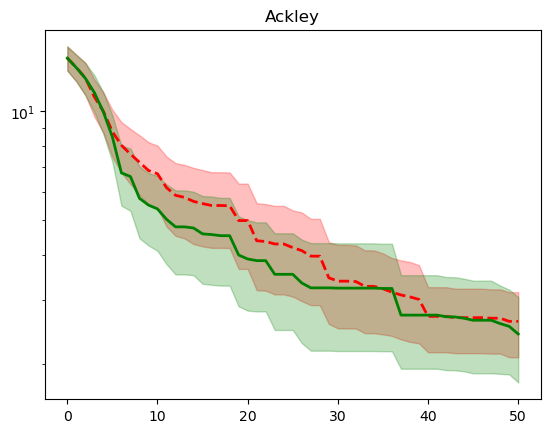

In [100]:
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='logEI',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='logEI*',color='green',linestyle='-',error_bound=True)

plt.title('Ackley')

Text(0.5, 1.0, 'Branin')

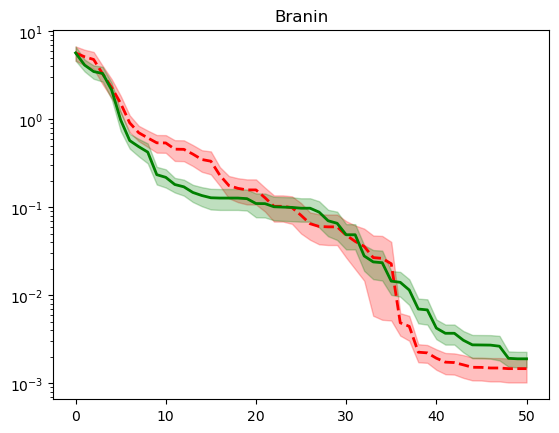

In [115]:
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='logEI',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='logEI*',color='green',linestyle='-',error_bound=True)

plt.title('Branin')

Text(0.5, 1.0, 'Beale')

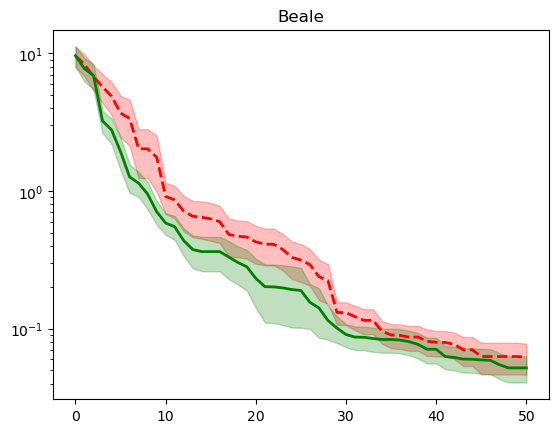

In [110]:
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='logEI',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='logEI*',color='green',linestyle='-',error_bound=True)

plt.title('Beale')

Text(0.5, 1.0, 'SixHumpCamel')

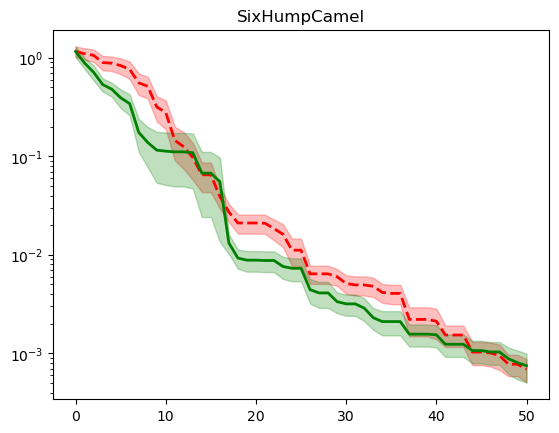

In [105]:
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='logEI',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='logEI*',color='green',linestyle='-',error_bound=True)

plt.title('SixHumpCamel')

Text(0.5, 1.0, 'Push')

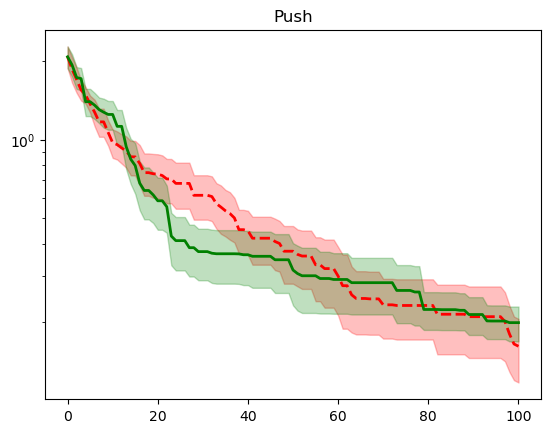

In [121]:
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='logEI',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='logEI*',color='green',linestyle='-',error_bound=True)

plt.title('Push')

# ERM

In [12]:
for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim
    N = 10
    fstar = information['fstar']
    
    print('fstar is: ',fstar)
    
    if dim <=3:
        step_size = 2
        iter_num = 50
    elif dim<=7:
        step_size = 3
        iter_num = 100 #120
    else:
        step_size = 4
        iter_num = 200
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,4**2]
    noise = 1e-6
    
    print(information['name'])

    ###################################### ERM ##############################################
    BO_ERM = []
    for exp in range(N):

        print(exp)  
        seed = exp
        
        Trans = False

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
                    [fun(x) for x in X_BO], dtype=dtype, device=device
                ).reshape(-1,1)

        best_record = [Y_BO.min().item()]

        np.random.seed(1234)

        for i in range(iter_num):

            print(i)
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            fstar_standard = (fstar - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            if not Trans:
                minimal = np.min(train_Y)
                if i%step_size == 0:
                    parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
                        
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
                m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
                m.Gaussian_noise.fix(noise)

                standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
                
                beta = np.sqrt(np.log(train_X.shape[0]))
                _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
                if lcb < fstar_standard:
                    Trans = True
                    #print('transform!')
                
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                print('noise: ',noise)
            
            else:    
                print('trans!')                    
                train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
                mean_temp = np.mean(train_Y_transform)
                
                if i%step_size == 0:
                    parameters = opt_model_MLE(train_X,(train_Y_transform-mean_temp),dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range) 
                    lengthscale = parameters[0]
                    variance = parameters[1]
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
                m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
                m.Gaussian_noise.fix(noise)
                standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
                print(standard_next_X)
                
            
            
            if np.any(np.abs((standard_next_X - train_X)).sum(axis=1) <= (dim*3e-4)):
                print('random')
                X_next = get_initial_points(bounds, 1,device,dtype,seed=i)
            
            else:        
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)     
            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)

            best_value = float(Y_BO.min())
            best_record.append(best_value)
            print(best_record[-1])
            
            noise = variance*10**(-5)   #adaptive noise
            noise = np.round(noise, -int(np.floor(np.log10(noise))))
            print('noise: ',noise)


        best_record = np.array(best_record)
        BO_ERM.append(best_record)

fstar is:  0.397887
Branin2D
0
0
noise:  1e-05
3.5451968551073154
noise:  1e-05
1
trans!
[0.56412823 0.01780814]
3.5451968551073154
noise:  1e-05
2
trans!
[0.59398911 0.05021846]
3.5451968551073154
noise:  3e-06
3
trans!
[0.52961168 0.08929023]
1.7826303910614154
noise:  3e-06
4
trans!
[0.54546148 0.07813001]
1.55446872352808
noise:  4e-06
5
trans!
[0.54406039 0.07931899]
1.5450100841786458
noise:  4e-06
6
trans!
[0.54424502 0.07973411]
random
1.5450100841786458
noise:  5e-06
7
trans!
[0.5506867  0.10858081]
0.7740789836255857
noise:  5e-06
8
trans!
[0.5515785 0.12861  ]
0.5415989659505929
noise:  6e-06
9
trans!
[0.55030118 0.13572574]
0.48236171765417346
noise:  6e-06
10
trans!
[0.54829716 0.14078225]
0.44074157963126837
noise:  7e-06
11
trans!
[0.54643683 0.14484299]
0.41597181317895426
noise:  7e-06
12
trans!
[0.54476081 0.1480074 ]
0.40316414601079487
noise:  9e-06
13
trans!
[0.54426649 0.14939742]
0.4005738434488535
noise:  9e-06
14
trans!
[0.54388291 0.1504158 ]
0.399252244695514

KeyboardInterrupt: 

In [8]:
np.any(np.abs((standard_next_X - train_X)).sum(axis=1) <= (dim*3e-4))

False

In [9]:
np.abs((standard_next_X - train_X)).sum(axis=1).shape

(9,)

In [4]:
X_max

array([0.57876339, 0.03712194])

In [2]:
from obj_functions import obj_function

fun = obj_function.XGBoost(task='skin', seed=1234)
bounds = fun.bounds

X_BO = get_initial_points(bounds, 18,device,dtype,seed=1234)
Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

In [3]:
Y_BO

tensor([[20.6867],
        [ 1.9261],
        [ 2.0431],
        [20.1045],
        [20.1126],
        [ 2.3995],
        [20.1153],
        [20.1017],
        [20.0691],
        [ 1.8635],
        [ 1.9098],
        [20.4636],
        [20.1398],
        [20.0800],
        [ 2.5463],
        [20.0827],
        [20.2350],
        [20.1099]], dtype=torch.float64)

In [1]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
import obj_functions.push_problems
import obj_functions.lunar_lander
import obj_functions.rover_problems
from  obj_functions.obj_function import Sphere
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


function_information = []

temp={}
temp['name']='Rover8D' 
temp['function']= obj_functions.rover_problems.rover8(negate=False)
temp['fstar'] =  0.
function_information.append(temp)



for information in function_information:

    fun = information['function']
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    n_init = 4*dim

    
    fstar = information['fstar']
    
    print('fstar is: ',fstar)
    
    if dim <=3:
        step_size = 2
        iter_num = 50
        N = 100
    elif dim<=5:
        step_size = 3
        iter_num = 100
        N = 8
    else:
        step_size = 1
        iter_num = 60 #200
        N = 4
        
    lengthscale_range = [0.001,2]
    variance_range = [0.001**2,20]
    noise = 1e-6
    
    print(information['name'])
        
 
#  ######################## SlogGP+logEI#######################################
    LogEI_noboundary = []
    boundary_holder = []
    variance_holder = []

    for exp in range(N):

        seed = exp
       
        print(exp)

        X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
        Y_BO = torch.tensor(
            [fun(x) for x in X_BO], dtype=dtype, device=device
        ).reshape(-1,1)

        best_record = [Y_BO.min().item()]
        np.random.seed(1234)
       
        boundarys = []
        variances = []

        Train = False

        for i in range(iter_num):

                print('inner loop: ',i)
                print(Train)
               
                train_Y = Y_BO.numpy()
               
                if i%step_size == 0 or Train :
                    Y_min = np.min(train_Y)
                    Y_std = np.std(train_Y-Y_min)
                   
                fstar_shifted = fstar -Y_min # shifted lower bound
                train_Y = train_Y - Y_min  # shift Y
               
                #scalise Y_shift and fstar_shift
                train_Y = train_Y/Y_std
                fstar_shifted = fstar_shifted/Y_std
           
   
               
                train_X = normalize(X_BO, bounds)
                train_X = train_X.numpy()
               
                lower = -np.min(train_Y)+10**(-6)
                if Y_std<=2.0:
                    upper = -fstar_shifted+100
                else:
                    upper = -fstar_shifted+30
                   
                c_range = [lower,upper]

                if i%step_size == 0 or Train:
                   
                    parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
       
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    c = parameters[2]
               
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('lower bound is ',-c*Y_std+Y_min)
               
                   
                boundarys.append(-c*Y_std+Y_min)
                variances.append(variance)
               
               
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
               
               
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)
               
                np.random.seed(i)
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,
                                                        f_mean=mean_warp_Y)
                X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
                Y_next = fun(X_next).reshape(-1,1)

                # Append data
                X_BO = torch.cat((X_BO, X_next), dim=0)
                Y_BO = torch.cat((Y_BO, Y_next), dim=0)
               
                best_record.append(Y_BO.min().item())
                print(best_record[-1])
               
                noise = variance*10**(-5)   #adaptive noise
                noise = np.round(noise, -int(np.floor(np.log10(noise))))
                #print('noise: ',noise)

                if Y_BO.min().item()<=-c*Y_std+Y_min:
                     Train = True
                else:
                     Train = False
               
               
        best_record = np.array(best_record)        
        LogEI_noboundary.append(best_record)
       
        boundarys = np.array(boundarys)
        boundary_holder.append(boundarys)
       
        variances = np.array(variances)
        variance_holder.append(variances)
   

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


fstar is:  0.0
Rover8D
0
inner loop:  0
False
lengthscale is  0.9356935028903656
variance is  0.06306863541568841
lower bound is  -3.5154923776239935
2.1022205698287975
inner loop:  1
False
lengthscale is  0.6739534822074676
variance is  0.009917344803734527
lower bound is  -11.35635053220387
1.920086486932476
inner loop:  2
False
lengthscale is  0.6832585520076545
variance is  0.018801450700649345
lower bound is  -6.912272186173265
1.920086486932476
inner loop:  3
False
lengthscale is  0.6682747816625619
variance is  0.019856494779601035
lower bound is  -6.375326891808411
1.8620503701931828
inner loop:  4
False
lengthscale is  0.6770657797208732
variance is  0.026204656422574
lower bound is  -4.993555633357786
1.8620503701931828
inner loop:  5
False
lengthscale is  0.6345746753580829
variance is  0.008721243024586328
lower bound is  -11.97910542917425
1.8620503701931828
inner loop:  6
False
lengthscale is  0.6152554953484155
variance is  0.008308882650426475
lower bound is  -12.240285

KeyboardInterrupt: 